# <img style="float: left; padding-right: 10px; width: 45px" src="https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/iacs.png"> Data Science 2: Advanced Topics in Data Science 
## Lab 8: Recurrent Neural Networks


**Harvard University**<br/>
**Spring 2025**<br/>
**Instructors**: Pavlos Protopapas, Natesh Pillai, and Chris Gumb

<hr style="height:2pt">

In [1]:
## RUN THIS CELL TO PROPERLY HIGHLIGHT THE EXERCISES
import requests
from IPython.core.display import HTML
styles = requests.get("https://raw.githubusercontent.com/Harvard-IACS/2019-CS109B/master/content/styles/cs109.css").text
HTML(styles)

## Learning Objectives

By the end of this lab, you should understand:
- how to perform basic preprocessing on text data
- the layers used in `keras` to construct RNNs and its variants (GRU, LSTM)
- how the model's task (i.e., many-to-1, many-to-many) affects architecture choices

<a id="contents"></a>

## Notebook Contents
- [**IMDB Review Dataset**](#imdb)
- [**Preprocessing Text Data**](#prep)
    - [Tokenization](#token)
    - [Padding](#pad)
    - [Numerical Encoding](#encode)
- [**Movie Review Sentiment Analysis**](#models)
    - [Naive FFNN](#ffnn)
    - [Embedding Layer](#embed)
    - [1D CNN](#cnn)
    - [Vanilla RNN](#rnn)
    - [Vanishing/Exploding Gradients](#vanish)
    - [GRU](#gru)
    - [LSTM](#lstm)
    - [BiDirectional Layer](#bidir)
    - [Deep RNNs](#deep)
    - [TimeDistributed Layer](#timedis)
    - [RepeatVector Layer](#repeatvec)
    - [CNN + RNN](#cnnrnn)


In [2]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.datasets import imdb
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.layers import BatchNormalization, Bidirectional, Dense, Embedding, GRU, LSTM, SimpleRNN,\
                                    Input, TimeDistributed, Dropout, RepeatVector
from tensorflow.keras.layers import Conv1D, Conv2D, Flatten, MaxPool1D, MaxPool2D, Lambda
from tensorflow.keras.callbacks import EarlyStopping, LambdaCallback, ModelCheckpoint
from tensorflow.keras.initializers import Constant
from tensorflow.keras.preprocessing import sequence
from sklearn.model_selection import train_test_split
import tensorflow_datasets
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import os, re, sys
# fix random seed for (some) reproducibility
np.random.seed(109)
# Use mixed precision for optimal performance
keras.mixed_precision.set_global_policy("mixed_float16")

2025-04-04 00:51:30.002183: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-04-04 00:51:30.002220: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-04-04 00:51:30.002927: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-04-04 00:51:30.007737: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: NVIDIA L4, compute capability 8.9


## Case Study: IMDB Review Classifier 
<img src='fig/manyto1.png' width='300px'>

Let's frame our discussion of RNNS around the example of a text classifier. Specifically, We'll build and evaluate various models that all attempt to descriminate between positive and negative reviews through the Internet Movie Database (IMDB). The dataset is again made available to us through the tensorflow datasets API.

In [3]:
import tensorflow_datasets

In [4]:
(train, test), info = tensorflow_datasets.load('imdb_reviews',
                                               split=['train', 'test'],
                                               with_info=True)


2025-04-03 21:07:45.800951: W external/local_tsl/tsl/platform/cloud/google_auth_provider.cc:184] All attempts to get a Google authentication bearer token failed, returning an empty token. Retrieving token from files failed with "NOT_FOUND: Could not locate the credentials file.". Retrieving token from GCE failed with "FAILED_PRECONDITION: Error executing an HTTP request: libcurl code 6 meaning 'Could not resolve hostname', error details: Could not resolve host: metadata.google.internal".


Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/3 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/25000 [00:00<?, ? examples/s]

Shuffling /shared/home/cwg194/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incompleteYEFXG9/imdb_reviews-…

Generating test examples...:   0%|          | 0/25000 [00:00<?, ? examples/s]

Shuffling /shared/home/cwg194/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incompleteYEFXG9/imdb_reviews-…

Generating unsupervised examples...:   0%|          | 0/50000 [00:00<?, ? examples/s]

Shuffling /shared/home/cwg194/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incompleteYEFXG9/imdb_reviews-…

Dataset imdb_reviews downloaded and prepared to /shared/home/cwg194/tensorflow_datasets/imdb_reviews/plain_text/1.0.0. Subsequent calls will reuse this data.


2025-04-03 21:08:12.788878: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1929] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 20763 MB memory:  -> device: 0, name: NVIDIA L4, pci bus id: 0000:31:00.0, compute capability: 8.9


The helpful `info` object provides details about the dataset.

In [5]:
info

tfds.core.DatasetInfo(
    name='imdb_reviews',
    full_name='imdb_reviews/plain_text/1.0.0',
    description="""
    Large Movie Review Dataset. This is a dataset for binary sentiment
    classification containing substantially more data than previous benchmark
    datasets. We provide a set of 25,000 highly polar movie reviews for training,
    and 25,000 for testing. There is additional unlabeled data for use as well.
    """,
    config_description="""
    Plain text
    """,
    homepage='http://ai.stanford.edu/~amaas/data/sentiment/',
    data_dir=PosixGPath('/tmp/tmp4nakntiotfds'),
    file_format=tfrecord,
    download_size=80.23 MiB,
    dataset_size=129.83 MiB,
    features=FeaturesDict({
        'label': ClassLabel(shape=(), dtype=int64, num_classes=2),
        'text': Text(shape=(), dtype=string),
    }),
    supervised_keys=('text', 'label'),
    disable_shuffling=False,
    splits={
        'test': <SplitInfo num_examples=25000, num_shards=1>,
        'train': <SplitInfo

We see that the dataset consists of text reviews and binary good/bad labels. Here are two examples:

In [6]:
# display the first 'bad' and 'good' movie reviews in the training data
labels = {0: 'bad', 1: 'good'}
seen = {'bad': False, 'good': False}
for review in train:
    label = review['label'].numpy()
    if not seen[labels[label]]:
        print(f"text:\n{review['text'].numpy().decode()}\n")
        print(f"label: {labels[label]}\n")
        seen[labels[label]] = True
    if all(val == True for val in seen.values()):
        break

text:
This was an absolutely terrible movie. Don't be lured in by Christopher Walken or Michael Ironside. Both are great actors, but this must simply be their worst role in history. Even their great acting could not redeem this movie's ridiculous storyline. This movie is an early nineties US propaganda piece. The most pathetic scenes were those when the Columbian rebels were making their cases for revolutions. Maria Conchita Alonso appeared phony, and her pseudo-love affair with Walken was nothing but a pathetic emotional plug in a movie that was devoid of any real meaning. I am disappointed that there are movies like this, ruining actor's like Christopher Walken's good name. I could barely sit through it.

label: bad

text:
This is the kind of film for a snowy Sunday afternoon when the rest of the world can go ahead with its own business as you descend into a big arm-chair and mellow for a couple of hours. Wonderful performances from Cher and Nicolas Cage (as always) gently row the pl

2025-04-03 21:08:13.230255: W tensorflow/core/kernels/data/cache_dataset_ops.cc:858] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


Great! But unfortunately, computers can read! 📖--🤖❓

## Preprocessing Text Data <div id='prep'>

Computers have no built-in knowledge of language and cannot understand text data in the way that humans do -- at least not without some help! The first crucial step in natural language processing is to clean and preprocess your data so that your algorithms and models can make use of it.
    
We'll look at a few preprocess steps:
- tokenization
- padding
- numerical encoding
        
Depending on your NLP task, you may want to take additional preprocessing steps which we will not cover here. These can include:
- converting all characters to lowercase
- treating each punctuation mark as a token (e.g., , . ! ? are each separate tokens)
- removing punctuation altogether
- separating each sentence with a unique symbol (e.g., <S> and </S>)
- removing words that are incredibly common (e.g., function words, (in)definite articles). These are referred to as 'stopwords').
- Lemmatizing (replacing words with their 'dictionary entry form')
- Stemming (removing grammatical morphemes)
    
Useful NLP Python libraries such as [NLTK](https://www.nltk.org/) and [spaCy](https://spacy.io/) provide built in methods for many of these preprocessing steps.

<div class='exercise' id='token'><b>Tokenization</b></div></br>

**Tokens** are the atomic units of meaning which our model will be working with. What should these units be? These could be characters, words, or even sentences. For our movie review classifier we will be working at the word level.

For this example we will process just a subset of the original dataset.

In [7]:
SAMPLE_SIZE = 10
subset = train.take(SAMPLE_SIZE)
next(iter(subset))

2025-04-03 21:08:13.283452: W tensorflow/core/kernels/data/cache_dataset_ops.cc:858] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


{'label': <tf.Tensor: shape=(), dtype=int64, numpy=0>,
 'text': <tf.Tensor: shape=(), dtype=string, numpy=b"This was an absolutely terrible movie. Don't be lured in by Christopher Walken or Michael Ironside. Both are great actors, but this must simply be their worst role in history. Even their great acting could not redeem this movie's ridiculous storyline. This movie is an early nineties US propaganda piece. The most pathetic scenes were those when the Columbian rebels were making their cases for revolutions. Maria Conchita Alonso appeared phony, and her pseudo-love affair with Walken was nothing but a pathetic emotional plug in a movie that was devoid of any real meaning. I am disappointed that there are movies like this, ruining actor's like Christopher Walken's good name. I could barely sit through it.">}

The TFDS format allows for the construction of efficient preprocessing pipelines. But for our own preprocessing example we will be primarily working with Python `list` objects. This gives us a chance to practice the Python **list comprehension** which is a powerful tool to have at your disposal. It will serve you well when processing arbitrary text which may not already be in a nice TFDS format (such as in the HW 😉).

We'll convert our data subset into X and y lists.

In [8]:
X = [x['text'].numpy().decode() for x in subset]
y = [x['label'].numpy() for x in subset]

2025-04-03 21:08:13.351532: W tensorflow/core/kernels/data/cache_dataset_ops.cc:858] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
2025-04-03 21:08:13.374922: W tensorflow/core/kernels/data/cache_dataset_ops.cc:858] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


In [9]:
print(f'X has {len(X)} reviews')
print(f'y has {len(y)} labels')

X has 10 reviews
y has 10 labels


In [10]:
N_CHARS = 20
print(f'First {N_CHARS} characters of all reviews:\n{[x[:20]+"..." for x in X]}\n')
print(f'All labels:\n{y}')

First 20 characters of all reviews:
['This was an absolute...', 'I have been known to...', 'Mann photographs the...', 'This is the kind of ...', 'As others have menti...', 'This is a film which...', 'Okay, you have:<br /...', 'The film is based on...', 'I really love the se...', "Sure, this one isn't..."]

All labels:
[0, 0, 0, 1, 1, 1, 0, 0, 0, 0]


Each observation in `X` is a review. A review is a `str` object which we can think of as a sequence of characters. This is indeed how Python treats strings as made clear by how we are printing 'slices' of each review in the code cell above.<br>

We'll see a bit later that you can in fact sucessfully train a neural network on text data at the character level.

But for the moment we will work at the word level, treating the word level. This means our observations should be organized as **sequences of words** rather than sequences of characters.

In [11]:
# list comprehensions again to the rescue!
X = [x.split() for x in X]
# The same thing can be accomplished with:
# list(map(str.split, X))
# but that is much harder to parse! O_o

Now let's look at the first 10 **tokens** in the first 2 reviews.

In [12]:
X[0][:10], X[1][:10]

(['This',
  'was',
  'an',
  'absolutely',
  'terrible',
  'movie.',
  "Don't",
  'be',
  'lured',
  'in'],
 ['I',
  'have',
  'been',
  'known',
  'to',
  'fall',
  'asleep',
  'during',
  'films,',
  'but'])

<div class='exercise' id='pad'><b>Padding</b></div></br>

Let's take a look at the lengths of the reviews in our subset.

In [13]:
[len(x) for x in X]

[116, 112, 132, 88, 81, 289, 557, 111, 223, 127]

If we were training our RNN one sentence at a time, it would be okay to have sentences of varying lengths. However, as with any neural network, it can be sometimes be advantageous to train inputs in batches. When doing so with RNNs, our input tensors need to be of the same length/dimensions.

Here are two examples of tokenized reviews padded to have a length of 5.
```
['I', 'loved', 'it', '<PAD>', '<PAD>']
['It', 'stinks', '<PAD>', '<PAD>', '<PAD>']
```
Now let's pad our own examples. Note that 'padding' in this context also means truncating sequences that are longer than our specified max length.

In [14]:
MAX_LEN = 500
PAD = '<PAD>'
# truncate
X = [x[:MAX_LEN] for x in X]
# pad
# note: prepadding is usually preferable
for x in X:
    while len(x) < MAX_LEN:
        x.append(PAD)

In [15]:
[len(x) for x in X]

[500, 500, 500, 500, 500, 500, 500, 500, 500, 500]

Now all reviews are of a uniform length!

<div class='exercise' id='encode'><b>Numerical Encoding</b></div></br>

If each review in our dataset is an observation, then the features of each observation are the tokens, in this case, words. But these words are still strings. Our machine learning methods require us to be able to multiple our features by weights. If we want to use these words as inputs for a neural network we'll have to convert them into some numerical representation.

One solution is to create a one-to-one mapping between unique words and integers.

If the five sentences below were our entire corpus, our conversion would look this:

1. i have books - [1, 4, 2]
2. interesting books are useful [11,2,9,8]
3. i have computers [1,4,3]
4. computers are interesting and useful [3,5,11,10,8]
5. books and computers are both valuable. [2,10,3,9,13,12]
6. bye bye [7,7]

I-1, books-2, computers-3, have-4, are-5, computers-6,bye-7, useful-8, are-9, and-10,interesting-11, valuable-12, both-13

To accomplish this we'll first need to know what all the unique words are in our dataset.

In [16]:
all_tokens = [word for review in X for word in review]

In [17]:
# sanity check
len(all_tokens), sum([len(x) for x in X])

(5000, 5000)

Casting our `list` of words into a `set` is a great way to get all the *unique* words in the data.

In [18]:
vocab = sorted(set(all_tokens))
print('Unique Words:', len(vocab))

Unique Words: 892


Now we need to create a mapping from words to integers. For this will a **dictionary comprehension**.

In [19]:
word2idx = {word: idx for idx, word in enumerate(vocab)}

In [20]:
word2idx

{'"Absolute': 0,
 '"Bohlen"-Fan': 1,
 '"Brideshead': 2,
 '"Candy"?).': 3,
 '"City': 4,
 '"Dieter': 5,
 '"Dieter"': 6,
 '"Dragonfly"': 7,
 '"I\'ve': 8,
 '"Lady."<br': 9,
 '"London': 10,
 '"Make': 11,
 '"Miss"': 12,
 '"Mr': 13,
 '"Mrs."': 14,
 '"actors"': 15,
 '"dewy-eyed."<br': 16,
 '"hey,': 17,
 '"meanwhile,")': 18,
 '"men"': 19,
 "'Where": 20,
 "'em": 21,
 "'round": 22,
 '(Backbone': 23,
 '(Barbarella).': 24,
 '(Brit': 25,
 '(I': 26,
 '(Jeremy': 27,
 '(Remember': 28,
 '(YOU': 29,
 '(as': 30,
 '(at': 31,
 '(not': 32,
 '(the': 33,
 "(there's": 34,
 '(they': 35,
 '(we': 36,
 '(what': 37,
 '(when,': 38,
 '(yes': 39,
 '-': 40,
 '.': 41,
 '/><br': 42,
 '/>Ah,': 43,
 '/>And': 44,
 '/>But': 45,
 '/>Canadian': 46,
 '/>David': 47,
 '/>First': 48,
 '/>Henceforth,': 49,
 '/>Joanna': 50,
 '/>Journalist': 51,
 '/>Nothing': 52,
 '/>OK,': 53,
 '/>Penelope': 54,
 '/>Peter': 55,
 '/>Second': 56,
 '/>So': 57,
 '/>Susan': 58,
 '/>Thank': 59,
 '/>Third': 60,
 '/>To': 61,
 '/>When': 62,
 '/>Wrong!': 63,
 '

We repeat the process, this time mapping integers to words.

In [21]:
idx2word = {idx: word for idx, word in enumerate(vocab)}

In [22]:
idx2word

{0: '"Absolute',
 1: '"Bohlen"-Fan',
 2: '"Brideshead',
 3: '"Candy"?).',
 4: '"City',
 5: '"Dieter',
 6: '"Dieter"',
 7: '"Dragonfly"',
 8: '"I\'ve',
 9: '"Lady."<br',
 10: '"London',
 11: '"Make',
 12: '"Miss"',
 13: '"Mr',
 14: '"Mrs."',
 15: '"actors"',
 16: '"dewy-eyed."<br',
 17: '"hey,',
 18: '"meanwhile,")',
 19: '"men"',
 20: "'Where",
 21: "'em",
 22: "'round",
 23: '(Backbone',
 24: '(Barbarella).',
 25: '(Brit',
 26: '(I',
 27: '(Jeremy',
 28: '(Remember',
 29: '(YOU',
 30: '(as',
 31: '(at',
 32: '(not',
 33: '(the',
 34: "(there's",
 35: '(they',
 36: '(we',
 37: '(what',
 38: '(when,',
 39: '(yes',
 40: '-',
 41: '.',
 42: '/><br',
 43: '/>Ah,',
 44: '/>And',
 45: '/>But',
 46: '/>Canadian',
 47: '/>David',
 48: '/>First',
 49: '/>Henceforth,',
 50: '/>Joanna',
 51: '/>Journalist',
 52: '/>Nothing',
 53: '/>OK,',
 54: '/>Penelope',
 55: '/>Peter',
 56: '/>Second',
 57: '/>So',
 58: '/>Susan',
 59: '/>Thank',
 60: '/>Third',
 61: '/>To',
 62: '/>When',
 63: '/>Wrong!',
 6

Now, perform the mapping to encode the observations in our subset. Note the use of ***nested list comprehensions***!

In [23]:
X_proc = [[word2idx[word] for word in review] for review in X]
X_proc[0][:10], X_proc[1][:10]

([211, 851, 272, 233, 793, 587, 109, 303, 557, 517],
 [131, 495, 308, 536, 819, 436, 289, 406, 449, 327])

`X_proc` is a list of lists but if we are going to feed it into a `keras` model we should convert both it and `y` into `numpy` arrays.

In [24]:
X_proc = np.hstack(X_proc).reshape(-1, MAX_LEN)
y = np.array(y)
X_proc, y

(array([[211, 851, 272, ...,  69,  69,  69],
        [131, 495, 308, ...,  69,  69,  69],
        [160, 649, 799, ...,  69,  69,  69],
        ...,
        [206, 445, 525, ...,  69,  69,  69],
        [131, 687, 552, ...,  69,  69,  69],
        [201, 810, 622, ...,  69,  69,  69]]),
 array([0, 0, 0, 1, 1, 1, 0, 0, 0, 0]))

Now, just to prove that we've successfully processed the data, we perform a test train split and feed it into a FNN.

In [25]:
X_train, X_test, y_train, y_test = train_test_split(X_proc, y, test_size=0.2, stratify=y)

In [26]:
model = Sequential()

model.add(Dense(8, activation='relu',input_dim=MAX_LEN))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())

model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=5, batch_size=2, verbose=2)

scores = model.evaluate(X_test, y_test, verbose=0)
print("Accuracy: %.2f%%" % (scores[1]*100))

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 8)                 4008      
                                                                 
 dense_1 (Dense)             (None, 1)                 9         
                                                                 
Total params: 4017 (15.69 KB)
Trainable params: 4017 (15.69 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None
Epoch 1/5


2025-04-03 21:08:15.924603: I external/local_xla/xla/service/service.cc:168] XLA service 0x151418020150 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-04-03 21:08:15.924637: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA L4, Compute Capability 8.9
2025-04-03 21:08:15.932274: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-04-03 21:08:15.952077: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8907
I0000 00:00:1743728896.012992   15316 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


4/4 - 2s - loss: 93.9375 - accuracy: 0.5000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000 - 2s/epoch - 401ms/step
Epoch 2/5
4/4 - 0s - loss: 77.1722 - accuracy: 0.6250 - val_loss: 0.0000e+00 - val_accuracy: 1.0000 - 24ms/epoch - 6ms/step
Epoch 3/5
4/4 - 0s - loss: 81.9375 - accuracy: 0.7500 - val_loss: 47.3750 - val_accuracy: 0.5000 - 24ms/epoch - 6ms/step
Epoch 4/5
4/4 - 0s - loss: 100.4609 - accuracy: 0.6250 - val_loss: 0.0000e+00 - val_accuracy: 1.0000 - 24ms/epoch - 6ms/step
Epoch 5/5
4/4 - 0s - loss: 81.0782 - accuracy: 0.6250 - val_loss: 47.9062 - val_accuracy: 0.5000 - 24ms/epoch - 6ms/step
Accuracy: 50.00%


It worked! But our subset was very small so we shouldn't get excited about the results above.<br>

**Preprocessed IMDB Data**

The IMDB dataset is very popular so `keras` also includes an alternative method for loading the data. This method can save us a lot of time for many reasons:
- Cleaned text with less meaningless punctuation
- Pre-tokenized and numerically encoded
- Allows us to specify maximum vocabulary size

In [27]:
from tensorflow.keras.datasets import imdb
import warnings
warnings.filterwarnings('ignore')

In [28]:
# We want to have a finite vocabulary to make sure that our word matrices are not arbitrarily small
MAX_VOCAB = 10000
INDEX_FROM = 3   # word index offset 
(X_train, y_train), (X_test, y_test) = keras.datasets.imdb.load_data(num_words=MAX_VOCAB,
                                                                     index_from=INDEX_FROM)

`get_word_index` will load a json object we can store in a dictionary. This gives us the word-to-integer mapping.

In [29]:
word2idx = keras.datasets.imdb.get_word_index(path='imdb_word_index.json')
word2idx = {k:(v + INDEX_FROM) for k,v in word2idx.items()}
word2idx["<PAD>"] = 0
word2idx["<START>"] = 1
word2idx["<UNK>"] = 2
word2idx["<UNUSED>"] = 3
word2idx

1641221/1641221 [==============================] - 0s 0us/step


{'fawn': 34704,
 'tsukino': 52009,
 'nunnery': 52010,
 'sonja': 16819,
 'vani': 63954,
 'woods': 1411,
 'spiders': 16118,
 'hanging': 2348,
 'woody': 2292,
 'trawling': 52011,
 "hold's": 52012,
 'comically': 11310,
 'localized': 40833,
 'disobeying': 30571,
 "'royale": 52013,
 "harpo's": 40834,
 'canet': 52014,
 'aileen': 19316,
 'acurately': 52015,
 "diplomat's": 52016,
 'rickman': 25245,
 'arranged': 6749,
 'rumbustious': 52017,
 'familiarness': 52018,
 "spider'": 52019,
 'hahahah': 68807,
 "wood'": 52020,
 'transvestism': 40836,
 "hangin'": 34705,
 'bringing': 2341,
 'seamier': 40837,
 'wooded': 34706,
 'bravora': 52021,
 'grueling': 16820,
 'wooden': 1639,
 'wednesday': 16821,
 "'prix": 52022,
 'altagracia': 34707,
 'circuitry': 52023,
 'crotch': 11588,
 'busybody': 57769,
 "tart'n'tangy": 52024,
 'burgade': 14132,
 'thrace': 52026,
 "tom's": 11041,
 'snuggles': 52028,
 'francesco': 29117,
 'complainers': 52030,
 'templarios': 52128,
 '272': 40838,
 '273': 52031,
 'zaniacs': 52133,

In [30]:
idx2word = {v: k for k,v in word2idx.items()}
idx2word

{34704: 'fawn',
 52009: 'tsukino',
 52010: 'nunnery',
 16819: 'sonja',
 63954: 'vani',
 1411: 'woods',
 16118: 'spiders',
 2348: 'hanging',
 2292: 'woody',
 52011: 'trawling',
 52012: "hold's",
 11310: 'comically',
 40833: 'localized',
 30571: 'disobeying',
 52013: "'royale",
 40834: "harpo's",
 52014: 'canet',
 19316: 'aileen',
 52015: 'acurately',
 52016: "diplomat's",
 25245: 'rickman',
 6749: 'arranged',
 52017: 'rumbustious',
 52018: 'familiarness',
 52019: "spider'",
 68807: 'hahahah',
 52020: "wood'",
 40836: 'transvestism',
 34705: "hangin'",
 2341: 'bringing',
 40837: 'seamier',
 34706: 'wooded',
 52021: 'bravora',
 16820: 'grueling',
 1639: 'wooden',
 16821: 'wednesday',
 52022: "'prix",
 34707: 'altagracia',
 52023: 'circuitry',
 11588: 'crotch',
 57769: 'busybody',
 52024: "tart'n'tangy",
 14132: 'burgade',
 52026: 'thrace',
 11041: "tom's",
 52028: 'snuggles',
 29117: 'francesco',
 52030: 'complainers',
 52128: 'templarios',
 40838: '272',
 52031: '273',
 52133: 'zaniacs',

We actually don't even have 10,000 unique tokens in the original dataset so we should update this variable. Otherwise we will have wasted space in embedding and output layers (this will make sense when you see the model architectures).

**Important:** This count includes the special tokens like `0` which represent padding.

In [31]:
# update vocab length
MAX_VOCAB = len(word2idx)

We can see that the text data is already preprocessed for us.

In [32]:
print('Number of reviews', len(X_train))
print('Length of first and fifth review before padding', len(X_train[0]) ,len(X_train[4]))
print('First review', X_train[0])
print('First label', y_train[0])

Number of reviews 25000
Length of first and fifth review before padding 218 147
First review [1, 14, 22, 16, 43, 530, 973, 1622, 1385, 65, 458, 4468, 66, 3941, 4, 173, 36, 256, 5, 25, 100, 43, 838, 112, 50, 670, 2, 9, 35, 480, 284, 5, 150, 4, 172, 112, 167, 2, 336, 385, 39, 4, 172, 4536, 1111, 17, 546, 38, 13, 447, 4, 192, 50, 16, 6, 147, 2025, 19, 14, 22, 4, 1920, 4613, 469, 4, 22, 71, 87, 12, 16, 43, 530, 38, 76, 15, 13, 1247, 4, 22, 17, 515, 17, 12, 16, 626, 18, 2, 5, 62, 386, 12, 8, 316, 8, 106, 5, 4, 2223, 5244, 16, 480, 66, 3785, 33, 4, 130, 12, 16, 38, 619, 5, 25, 124, 51, 36, 135, 48, 25, 1415, 33, 6, 22, 12, 215, 28, 77, 52, 5, 14, 407, 16, 82, 2, 8, 4, 107, 117, 5952, 15, 256, 4, 2, 7, 3766, 5, 723, 36, 71, 43, 530, 476, 26, 400, 317, 46, 7, 4, 2, 1029, 13, 104, 88, 4, 381, 15, 297, 98, 32, 2071, 56, 26, 141, 6, 194, 7486, 18, 4, 226, 22, 21, 134, 476, 26, 480, 5, 144, 30, 5535, 18, 51, 36, 28, 224, 92, 25, 104, 4, 226, 65, 16, 38, 1334, 88, 12, 16, 283, 5, 16, 4472, 113, 103

**Review Decoding**

Here's an example review using the index-to-word mapping we created from the loaded JSON file to view the a review in its original form.

In [33]:
def show_review(x):
    review = ' '.join([idx2word[idx] for idx in x])
    print(review)

show_review(X_train[0])

<START> this film was just brilliant casting location scenery story direction everyone's really suited the part they played and you could just imagine being there robert <UNK> is an amazing actor and now the same being director <UNK> father came from the same scottish island as myself so i loved the fact there was a real connection with this film the witty remarks throughout the film were great it was just brilliant so much that i bought the film as soon as it was released for <UNK> and would recommend it to everyone to watch and the fly fishing was amazing really cried at the end it was so sad and you know what they say if you cry at a film it must have been good and this definitely was also <UNK> to the two little boy's that played the <UNK> of norman and paul they were just brilliant children are often left out of the <UNK> list i think because the stars that play them all grown up are such a big profile for the whole film but these children are amazing and should be praised for wha

**Padding**

The only thing what isn't done for us is the padding. Looking at the distribution of lengths will help us determine what a reasonable length to pad to will be.

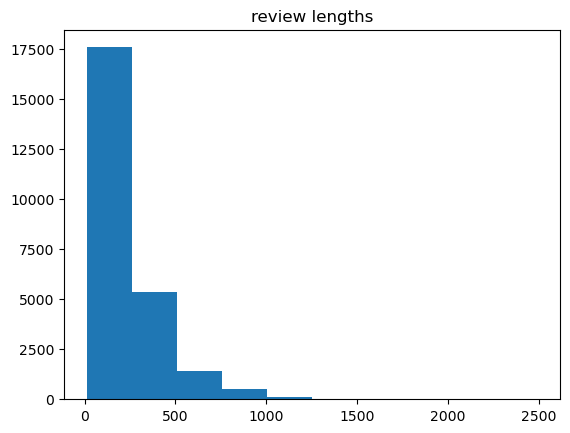

In [34]:
# Distribution of review lengths
plt.hist([len(x) for x in X_train])
plt.title('review lengths');

We saw one way of doing this earlier, but Keras actually has a built in `pad_sequences` helper function. This handles both padding and truncating. By default padding is added to the *beginning* of a sequence.

<div class="exercise"  style="background-color:#b3e6ff">
<b>Q</b>: Why might we want to truncate? Why might we want to pad from the beginning?
</div>

In [35]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [36]:
MAX_LEN = 500
X_train = pad_sequences(X_train, maxlen=MAX_LEN)
X_test = pad_sequences(X_test, maxlen=MAX_LEN)
print('Length of first and fifth review after padding', len(X_train[0]) ,len(X_train[4]))

Length of first and fifth review after padding 500 500


<div class='exercise' id='FFNN'><b>Model 1: Naive Feed-Forward Network</b></div></br>

Let us build a single-layer feed-forward net with a hidden layer of 250 nodes. Each input would be a 500-dim vector of tokens since we padded all our sequences to size 500.

<br>
<div class="exercise"  style="background-color:#b3e6ff">
<b>Q</b>: How would you calculate the number of parameters in this network?
</div>

In [37]:
model = Sequential(name='Naive_FFNN')
model.add(Dense(250, activation='relu',input_dim=MAX_LEN))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "Naive_FFNN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_2 (Dense)             (None, 250)               125250    
                                                                 
 dense_3 (Dense)             (None, 1)                 251       
                                                                 
Total params: 125501 (490.24 KB)
Trainable params: 125501 (490.24 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [38]:
model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=10, batch_size=128, verbose=2)

scores = model.evaluate(X_test, y_test, verbose=0)
print("Accuracy: %.2f%%" % (scores[1]*100))

Epoch 1/10
196/196 - 1s - loss: 191.8202 - accuracy: 0.5025 - val_loss: 90.5763 - val_accuracy: 0.5043 - 1s/epoch - 7ms/step
Epoch 2/10
196/196 - 1s - loss: 46.0562 - accuracy: 0.5830 - val_loss: 44.2539 - val_accuracy: 0.4996 - 546ms/epoch - 3ms/step
Epoch 3/10
196/196 - 1s - loss: 15.2216 - accuracy: 0.6588 - val_loss: 26.4614 - val_accuracy: 0.4964 - 541ms/epoch - 3ms/step
Epoch 4/10
196/196 - 1s - loss: 6.2277 - accuracy: 0.7146 - val_loss: 15.7935 - val_accuracy: 0.5026 - 540ms/epoch - 3ms/step
Epoch 5/10
196/196 - 1s - loss: 3.0387 - accuracy: 0.7570 - val_loss: 11.7361 - val_accuracy: 0.5029 - 539ms/epoch - 3ms/step
Epoch 6/10
196/196 - 1s - loss: 1.9168 - accuracy: 0.7740 - val_loss: 8.7116 - val_accuracy: 0.4974 - 539ms/epoch - 3ms/step
Epoch 7/10
196/196 - 1s - loss: 1.2677 - accuracy: 0.7971 - val_loss: 7.0700 - val_accuracy: 0.5000 - 539ms/epoch - 3ms/step
Epoch 8/10
196/196 - 1s - loss: 1.0722 - accuracy: 0.8030 - val_loss: 6.5899 - val_accuracy: 0.5011 - 540ms/epoch - 3ms

<div class="exercise"  style="background-color:#b3e6ff">
<b>Q</b>: Why was the performance so poor? How could we improve our tokenization?
</div>

<div class='exercise' id='FFNN_emb'><b>Model 2: Feed-Forward Network /w Embeddings</b></div></br>
<img src='fig/wordembedding2.png' width=450px>

One can view the embedding process as a linear projection from one vector space to another. For NLP, we usually use embeddings to project the sparse one-hot encodings of words on to a lower-dimensional continuous space so that the input surface is 'dense' and possibly smooth. Thus, one can view this embedding layer process as just a transformation from $\mathbb{R}^{inp}$ to $\mathbb{R}^{emb}$

This not only reduces dimensionality but also allows semantic similarities between tokens to be captured by 'similiarities' between the embedding vectors. This is not possible with one-hot encoding as all vectors there were orthogonal to one another. 

<img src='fig/wordembedding.png' width=450px>

It is also possible to load pretrained embeddings that were learned from giant corpora. This would be an instance of transfer learning.

If you are interested in learning more, start with the astromonically impactful papers of [word2vec](https://papers.nips.cc/paper/5021-distributed-representations-of-words-and-phrases-and-their-compositionality.pdf) and [GloVe](https://www.aclweb.org/anthology/D14-1162.pdf).

In Keras we use the [`Embedding`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Embedding) layer:
```
tf.keras.layers.Embedding(
    input_dim, output_dim, embeddings_initializer='uniform',
    embeddings_regularizer=None, activity_regularizer=None,
    embeddings_constraint=None, mask_zero=True, input_length=None, **kwargs
)
```
We'll need to specify the `input_dim` and `output_dim`. If working with sequences, as we are, you'll also need to set the `input_length`.

In [39]:
EMBED_DIM = 100

model = Sequential(name='FFNN_EMBED')
model.add(Embedding(MAX_VOCAB, EMBED_DIM, input_length=MAX_LEN, mask_zero=True))
model.add(Flatten())
model.add(Dense(250, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "FFNN_EMBED"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 500, 100)          8858800   
                                                                 
 flatten (Flatten)           (None, 50000)             0         
                                                                 
 dense_4 (Dense)             (None, 250)               12500250  
                                                                 
 dense_5 (Dense)             (None, 1)                 251       
                                                                 
Total params: 21359301 (81.48 MB)
Trainable params: 21359301 (81.48 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [40]:
model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=2, batch_size=128, verbose=2)

scores = model.evaluate(X_test, y_test, verbose=2)
print("Accuracy: %.2f%%" % (scores[1]*100))

Epoch 1/2
196/196 - 18s - loss: 0.5100 - accuracy: 0.7264 - val_loss: 0.2934 - val_accuracy: 0.8767 - 18s/epoch - 90ms/step
Epoch 2/2
196/196 - 12s - loss: 0.1471 - accuracy: 0.9444 - val_loss: 0.3100 - val_accuracy: 0.8730 - 12s/epoch - 63ms/step
782/782 - 1s - loss: 0.3100 - accuracy: 0.8730 - 960ms/epoch - 1ms/step
Accuracy: 87.30%


<div class='exercise' id='1D_CNN'><b>Model 3: 1-Dimensional Convolutional Network</b></div></br>
<img src='fig/1D-CNN.png'>

Text can be thought of as 1-dimensional sequence (a single, long vector) and we can apply 1D Convolutions over a set of word embeddings.<br>

More information on convolutions on text data can be found on [this blog](http://debajyotidatta.github.io/nlp/deep/learning/word-embeddings/2016/11/27/Understanding-Convolutions-In-Text/). If you want to learn more, read this [published and well-cited paper](https://www.aclweb.org/anthology/I17-1026.pdf).

<div class="exercise"  style="background-color:#b3e6ff">
<b>Q</b>: Why do we use Conv1D if our input, a sequence of word embeddings, is 2D?
</div>

In [41]:
model = Sequential(name='1D_CNN')
model.add(Embedding(MAX_VOCAB, EMBED_DIM, input_length=MAX_LEN, mask_zero=True))
model.add(Conv1D(filters=200, kernel_size=3, padding='same', activation='relu'))
model.add(MaxPool1D(pool_size=2))
model.add(Flatten())
model.add(Dense(250, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())

model.fit(X_train, y_train, epochs=2, batch_size=128)

scores = model.evaluate(X_test, y_test, verbose=0)
print("Accuracy: %.2f%%" % (scores[1]*100))

Model: "1D_CNN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 500, 100)          8858800   
                                                                 
 conv1d (Conv1D)             (None, 500, 200)          60200     
                                                                 
 max_pooling1d (MaxPooling1  (None, 250, 200)          0         
 D)                                                              
                                                                 
 flatten_1 (Flatten)         (None, 50000)             0         
                                                                 
 dense_6 (Dense)             (None, 250)               12500250  
                                                                 
 dense_7 (Dense)             (None, 1)                 251       
                                                            

<div class='exercise' id='rnn_model'><b>Model 4: Simple RNN</b></div></br>
<img src='fig/simplernn.png' width=300px>

At a high-level, an RNN is similar to a feed-forward neural network (FFNN) in that there is an input layer, a hidden layer, and an output layer. The input layer is fully connected to the hidden layer, and the hidden layer is fully connected to the output layer. However, the crux of what makes it a **recurrent** neural network is that the hidden layer for a given time _t_ is not only based on the input layer at time _t_ but also the hidden layer from time _t-1_.

Here's a popular blog post on [The Unreasonable Effectiveness of Recurrent Neural Networks](http://karpathy.github.io/2015/05/21/rnn-effectiveness/).

In Keras, the vanilla RNN unit is implemented the`SimpleRNN` layer:
```
tf.keras.layers.SimpleRNN(
    units, activation='tanh', use_bias=True,
    kernel_initializer='glorot_uniform',
    recurrent_initializer='orthogonal',
    bias_initializer='zeros', kernel_regularizer=None,
    recurrent_regularizer=None, bias_regularizer=None, activity_regularizer=None,
    kernel_constraint=None, recurrent_constraint=None, bias_constraint=None,
    dropout=0.0, recurrent_dropout=0.0, return_sequences=False, return_state=False,
    go_backwards=False, stateful=False, unroll=False, **kwargs
)
```
As you can see, recurrent layers in Keras take many arguments. We only need to be concerned with `units`, which specifies the size of the hidden state, and `return_sequences`, which will be discussed shortly. For the moment is it fine to leave this set to the default of `False`.

Due to the limitations of the vanilla RNN unit (more on that next) it tends not to be used much in practice. For this reason it seems that the Keras developers neglected to implement GPU acceleration for this layer! Notice how much slower the trainig is even for a network with far fewer parameters.

In [42]:
model = Sequential(name='SimpleRNN')
model.add(Embedding(MAX_VOCAB, EMBED_DIM, input_length=MAX_LEN, mask_zero=True))
model.add(SimpleRNN(100))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())

model.fit(X_train, y_train, epochs=3, batch_size=128)

scores = model.evaluate(X_test, y_test, verbose=0)
print("Accuracy: %.2f%%" % (scores[1]*100))

Model: "SimpleRNN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 500, 100)          8858800   
                                                                 
 simple_rnn (SimpleRNN)      (None, 100)               20100     
                                                                 
 dense_8 (Dense)             (None, 1)                 101       
                                                                 
Total params: 8879001 (33.87 MB)
Trainable params: 8879001 (33.87 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None
Epoch 1/3
196/196 [==============================] - 88s 438ms/step - loss: 0.6248 - accuracy: 0.6333
Epoch 2/3
196/196 [==============================] - 83s 423ms/step - loss: 0.3866 - accuracy: 0.8280
Epoch 3/3
196/196 [==============================] - 80s 410ms/step - lo

<div class='exercise' id='rnn_model'><b>Vanishing/Exploding Gradients</b></div></br>

<img src = "fig/backprop.png" width=500px>
<br>

We need to backpropogate through every time step to calculate the gradients used for our weight updates.

This requires the use of the chain rule which amounts to repeated multiplications.

This can cause two types of problems. First, this product can quickly 'explode,' becoming large, causing destructive updates to the model and numerical overflow. One hack to solve this problem is to **clip** the gradient at some threshold.

Alternatively, the gradient can 'vanish,' getting smaller and smaller as the gradient moves backwards in time. Gradient clipping will not help us here. If we can't propogate gradients suffuciently far back in time then our network will be unable to learn long temporal dependencies. This problem motivates the architecture of the GRU and LSTM units as substitutes for the 'vanilla' RNN.

<div class='exercise' id='rnn_model'><b>Model 5: GRU</b></div></br>
<img src='fig/gru.png' width=800px>

$X_{t}$: input<br>
$U$, $V$, and $\beta$: parameter matrices and vector<br>
$\tilde{h_t}$: candidate activation vector<br>
$h_{t}$: output vector<br>
$R_t$: reset gate<br>
$Z_t$: update gate<br>

The gates of the GRU allow for the gradients to flow more freely to previous time steps, helping to mitigate the vanishing gradient problem.

In Keras, the [`GRU`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/GRU) layer is used in exactly the same way as the `SimpleRNN` layer. 
```
tf.keras.layers.GRU(
    units, activation='tanh', recurrent_activation='sigmoid',
    use_bias=True, kernel_initializer='glorot_uniform',
    recurrent_initializer='orthogonal',
    bias_initializer='zeros', kernel_regularizer=None,
    recurrent_regularizer=None, bias_regularizer=None, activity_regularizer=None,
    kernel_constraint=None, recurrent_constraint=None, bias_constraint=None,
    dropout=0.0, recurrent_dropout=0.0, return_sequences=False, return_state=False,
    go_backwards=False, stateful=False, unroll=False, time_major=False,
    reset_after=True, **kwargs
)
```

Here we just swap it in to the previous architecture. Note how much faster it trains with GPU excelleration than the simple RNN!

In [43]:
model = Sequential(name='GRU')
model.add(Embedding(MAX_VOCAB, EMBED_DIM, input_length=MAX_LEN, mask_zero=True))
model.add(GRU(100))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())

model.fit(X_train, y_train, epochs=3, batch_size=64)

scores = model.evaluate(X_test, y_test, verbose=0)
print("Accuracy: %.2f%%" % (scores[1]*100))

Model: "GRU"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 500, 100)          8858800   
                                                                 
 gru (GRU)                   (None, 100)               60600     
                                                                 
 dense_9 (Dense)             (None, 1)                 101       
                                                                 
Total params: 8919501 (34.03 MB)
Trainable params: 8919501 (34.03 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None
Epoch 1/3
391/391 [==============================] - 235s 593ms/step - loss: 0.4262 - accuracy: 0.7975
Epoch 2/3
391/391 [==============================] - 217s 555ms/step - loss: 0.2403 - accuracy: 0.9079
Epoch 3/3
391/391 [==============================] - 211s 541ms/step - loss:

<div class='exercise' id='rnn_model'><b>Model 6: LSTM</b></div></br>
<img src='fig/lstm.png' width=600px>

The LSTM lacks the GRU's 'short cut' connection (see GRU's $h_t$ above).

The LSTM also has a distinct 'cell state' in addition to the hidden state. 

Futher reading: 
- [Understanding LSTM Networks](http://colah.github.io/posts/2015-08-Understanding-LSTMs/)
- [LSTM: A Search Space Odyssey](https://arxiv.org/abs/1503.04069)
- [An Empirical Exploration of Recurrent Network Architectures](http://proceedings.mlr.press/v37/jozefowicz15.pdf)

Again, Kera's [`LSTM`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/LSTM) works like all the other recurrent layers.
```
tf.keras.layers.LSTM(
    units, activation='tanh', recurrent_activation='sigmoid',
    use_bias=True, kernel_initializer='glorot_uniform',
    recurrent_initializer='orthogonal',
    bias_initializer='zeros', unit_forget_bias=True,
    kernel_regularizer=None, recurrent_regularizer=None, bias_regularizer=None,
    activity_regularizer=None, kernel_constraint=None, recurrent_constraint=None,
    bias_constraint=None, dropout=0.0, recurrent_dropout=0.0,
    return_sequences=False, return_state=False, go_backwards=False, stateful=False,
    time_major=False, unroll=False, **kwargs
)
```


In [44]:
model = Sequential(name='LSTM')
model.add(Embedding(MAX_VOCAB, EMBED_DIM, input_length=MAX_LEN, mask_zero=True))
model.add(LSTM(100))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())

model.fit(X_train, y_train, epochs=3, batch_size=64)

scores = model.evaluate(X_test, y_test, verbose=0)
print("Accuracy: %.2f%%" % (scores[1]*100))

Model: "LSTM"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (None, 500, 100)          8858800   
                                                                 
 lstm (LSTM)                 (None, 100)               80400     
                                                                 
 dense_10 (Dense)            (None, 1)                 101       
                                                                 
Total params: 8939301 (34.10 MB)
Trainable params: 8939301 (34.10 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None
Epoch 1/3


2025-04-03 21:26:05.350569: W tensorflow/core/common_runtime/type_inference.cc:339] Type inference failed. This indicates an invalid graph that escaped type checking. Error message: INVALID_ARGUMENT: expected compatible input types, but input 1:
type_id: TFT_OPTIONAL
args {
  type_id: TFT_PRODUCT
  args {
    type_id: TFT_TENSOR
    args {
      type_id: TFT_INT32
    }
  }
}
 is neither a subtype nor a supertype of the combined inputs preceding it:
type_id: TFT_OPTIONAL
args {
  type_id: TFT_PRODUCT
  args {
    type_id: TFT_TENSOR
    args {
      type_id: TFT_HALF
    }
  }
}

	for Tuple type infernce function 0
	while inferring type of node 'cond_36/output/_23'


391/391 [==============================] - 225s 568ms/step - loss: 0.4347 - accuracy: 0.8086
Epoch 2/3
391/391 [==============================] - 214s 548ms/step - loss: 0.3080 - accuracy: 0.8796
Epoch 3/3
391/391 [==============================] - 209s 535ms/step - loss: 0.2493 - accuracy: 0.9065
Accuracy: 86.16%


<div class='exercise' id='bidir'><b>BiDirectional Layer</b></div></br>
<img src='fig/bi-directional-RNN.png' width=600px>

We may want our model to learn dependencies in either direction. A **BiDirectional RNN** consists of two separate recurrent units. One processing the sequence from left to right, the other processes that same sequence but in reverse, from right to left. The output of the two units are then merged together (typically concatenated) and feed to the next layer of the network.<br>



Creating a Bidirection RNN in Keras is quite simple. We just 'wrap' a recurrent layer in the [`Bidirectional`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Bidirectional) layer. The default behavior is to concatenate the output from each direction.

```
tf.keras.layers.Bidirectional(
    layer, merge_mode='concat', weights=None, backward_layer=None,
    **kwargs
)
```

Example:
```
model = Sequential()
...
model.add(Bidirectional(SimpleRNN(n_nodes))
...
```

<div class='exercise' id='deep'><b>Deep RNNs</b></div></br>
<img src='fig/deeprnn.png' width=600px>

We may want to stack RNN layers one after another. But there is a problem. A recurrent layer expects to be given a sequence as input, and yet we can see that the recurrent layer in each of our models above outputs a single vector. This is because the default behavior of Keras's recurrent layers is to suppress the output until the final time step. If we want to have two recurrent units in a row then the first will have to given an output after each time step, thus providing a sequence to the 2nd recurrent layer.

We can have our recurrent layers output at each time step setting `return_sequences=True`.<br>
Example:
```
model = Sequential()
...
model.add(LSTM(100, return_sequences=True))
model.add(LSTM(100)
...
```

<div class='exercise' id='timedist'><b>TimeDistributed Layer</b></div></br>


[`TimeDistributed`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/TimeDistributed) is a 'wrapper' that applies a layer to all time steps of an input sequence.
```
tf.keras.layers.TimeDistributed(
    layer, **kwargs
)
```
Every input should be at least 3D, and the dimension of index one of the first input will be considered to be the temporal dimension.

Consider a batch of 32 video samples, where each sample is a 128x128 RGB image with channels_last data format, across 10 timesteps. The batch input shape is (32, 10, 128, 128, 3).

You can then use `TimeDistributed` to apply the same `Conv2D` layer to each of the 10 timesteps, independently:

In [45]:
from tensorflow import TensorShape

inputs = tf.keras.Input(shape=(10, 128, 128, 3))
conv_2d_layer = tf.keras.layers.Conv2D(64, (3, 3))
outputs = tf.keras.layers.TimeDistributed(conv_2d_layer)(inputs)
outputs.shape
TensorShape([None, 10, 126, 126, 64])

TensorShape([None, 10, 126, 126, 64])

<div class='exercise' id='repeatvec'><b>RepeatVector Layer</b></div></br>


The [`RepeatVector`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/TimeDistributed) repeats the output of a layer a specified number of times. Dimension changes from <br>
(batch_size, number_of_elements)<br>
to<br>
(batch_size, number_of_repetitions, number_of_elements)

This effectively generates a sequence from a single input.

In [46]:
model = Sequential()
model.add(Dense(2, input_dim=1))
model.add(RepeatVector(3))
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_11 (Dense)            (None, 2)                 4         
                                                                 
 repeat_vector (RepeatVecto  (None, 3, 2)              0         
 r)                                                              
                                                                 
Total params: 4 (16.00 Byte)
Trainable params: 4 (16.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


<div class="exercise"  style="background-color:#b3e6ff">
<b>Q</b>: Can you think of some tasks that would require the use of `RepeatVector`?
</div>

<div class='exercise' id='cnn_rnn'><b>Model 7: CNN + RNN</b></div></br>

CNNs are good at learning spatial features, and sentences can be thought of as 1-D spatial vectors (dimensionality is determined by the number of words in the sentence). We can then take the features learned by the CNN (after a maxpooling layer) and feed them into an RNN! We expect the CNN to be able to pick out invariant features across the 1-D spatial structure (i.e., sentence) that characterize good and bad sentiment. This learned spatial features may then be learned as sequences by a reccurent layer. The classification step is then performed by a final dense layer.

<div class="exercise"  style="background-color:#F5E4C3">
    <b>Exercise:</b> Build a CNN + Deep, BiDirectional GRU Model
</div>

Let's put together everything we've learned so far.<br>
Create a network with:
- word embeddings in a 100-dimensional space
- conv layer with 32 filters, kernels of width 3, 'same' padding, and ReLU activate
- max pooling of size 2
- 2 bidirectional GRU layers, each with 50 units *per direction*
- dense output layer for binary classification

In [47]:
model = Sequential(name='CNN_GRU')
# your code here
model.add(Embedding(MAX_VOCAB, 100, input_length=MAX_LEN, mask_zero=True))
model.add(Conv1D(filters=32, kernel_size=3, padding='same', activation='relu'))
model.add(MaxPool1D(pool_size=2))
model.add(Bidirectional(GRU(50, return_sequences=True)))
model.add(Bidirectional(GRU(50)))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "CNN_GRU"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_5 (Embedding)     (None, 500, 100)          8858800   
                                                                 
 conv1d_1 (Conv1D)           (None, 500, 32)           9632      
                                                                 
 max_pooling1d_1 (MaxPoolin  (None, 250, 32)           0         
 g1D)                                                            
                                                                 
 bidirectional (Bidirection  (None, 250, 100)          25200     
 al)                                                             
                                                                 
 bidirectional_1 (Bidirecti  (None, 100)               45600     
 onal)                                                           
                                                           

In [48]:
model.fit(X_train, y_train, epochs=3, batch_size=64)

scores = model.evaluate(X_test, y_test, verbose=0)
print("Accuracy: %.2f%%" % (scores[1]*100))

Epoch 1/3
391/391 [==============================] - 32s 70ms/step - loss: 0.3858 - accuracy: 0.8123
Epoch 2/3
391/391 [==============================] - 19s 48ms/step - loss: 0.1885 - accuracy: 0.9296
Epoch 3/3
391/391 [==============================] - 15s 37ms/step - loss: 0.1076 - accuracy: 0.9623
Accuracy: 88.26%


Using the `show_review` function we defined earlier...

What is the *worst* movie review in the test set according to your model? 🍅

In [49]:
preds = model.predict(X_test)
worst_review = X_test[preds.argmin()]
show_review(worst_review)

782/782 [==============================] - 8s 9ms/step
not renowned for his talents as a writer or a director but he has made some undeniably important films kids bully and to a lesser extent ken park all achieve their intended purpose shock <UNK> and even disgust these films are <UNK> in their content and use their controversial nature to expose very serious problems in modern youth kids exposed us to the <UNK> of a i d s and sexual <UNK> among the young bully touched upon similar issues ken park dealt somewhat ham <UNK> with sexual abuse and suburban <UNK> <UNK> all of these films exposed something horrifying and left a bad taste in your mouth br br <UNK> <UNK> is about a group of poor hispanic from south central las angeles who go to <UNK> go to beverly hills to <UNK> that's it br br <UNK> <UNK> is nothing br br it has no substance it has an essentially nonexistent narrative and like kids it features a cast of first time actors who were drawn out of the films setting however unlike 

What is the *best* movie review in the test set according to your model? 🏆

In [50]:
best_review = X_test[preds.argmax()]
show_review(best_review)

<PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD

<div class="exercise"  style="background-color:#F5E4C3">
    <b>End of Exercise</b>
</div>

🌈 **The End**